In [1]:
!pip install torch==1.12.0 --extra-index-url https://download.pytorch.org/whl/cu113
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     |██████████████▌                 | 834.1 MB 1.2 MB/s eta 0:13:28tcmalloc: large alloc 1147494400 bytes == 0x39c3a000 @  0x7f37820b6615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |██████████████████▍             | 1055.7 MB 1.2 MB/s eta 0:10:28tcmalloc: large alloc 1434370048 bytes == 0x7e290000 @  0x7f37820b6615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |███████████████████████▎        | 

In [2]:
import torch
print(torch.__version__)
from google.colab import drive
drive.mount('/content/drive')

1.12.0+cu113
Mounted at /content/drive


In [4]:
import torch
import numpy as np

import torch.nn.functional as F
import torch.nn as nn

from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt
from utilities import *
from nn_conv import NNConv, NNConv_old

from timeit import default_timer
import scipy.io



In [5]:
def normalizer(data):
    max_resp = []
    max_strain = []
    for j in range(len(data)):
        max_resp.append(max(data[j][2][:,0])) #epsilon_xx
        max_strain.append(max(data[j][1][:,0])) #epsilon_xx           
    mmax_strain = max(max_strain)
    mmax_resp = max(max_resp)
    mmax_coor = 200 #max(data[0][0,:])
    for j in range(len(data)):
        data[j][0] = data[j][0]/mmax_coor
        data[j][1] = data[j][1]/mmax_strain
        data[j][2] = (data[j][2])/mmax_resp
    return data, mmax_strain, mmax_resp, mmax_coor


def normalizer_t(data, mmax_strain, mmax_resp, mmax_coor):
    for j in range(len(data)):
        mmax_coor = max(data[j][0])
        data[j][0] = data[j][0]/mmax_coor
        data[j][1] = data[j][1]/mmax_strain
        data[j][2] = data[j][2]/mmax_resp
    return data


def denormalizer(coor, resp, pred, mmax_strain, mmax_resp, mmax_coor):
    coor = coor * mmax_coor
    resp = resp * mmax_resp
    pred = pred * mmax_resp
    return coor, resp, pred

class SCAMeshGenerator():
    def __init__(self, grid, input, output):
        self.grid = grid.reshape(-1,2)
        self.input = input
        self.output = output[:,1]
        self.d  = 2
    
    def get_grid(self):
        return torch.tensor(self.grid, dtype=torch.float)

    def get_input(self):
        return torch.tensor(self.input, dtype=torch.float)

    def get_output(self):
        return torch.tensor(self.output, dtype=torch.float)

    def ball_connectivity(self, r):
        pwd = sklearn.metrics.pairwise_distances(self.grid)
        self.edge_index = np.vstack(np.where(pwd <= r))
        self.n_edges = self.edge_index.shape[1]

        return torch.tensor(self.edge_index, dtype=torch.long)

    def gaussian_connectivity(self, sigma):
        pwd = sklearn.metrics.pairwise_distances(self.grid)
        rbf = np.exp(-pwd**2/sigma**2)
        sample = np.random.binomial(1,rbf)
        self.edge_index = np.vstack(np.where(sample))
        self.n_edges = self.edge_index.shape[1]
        return torch.tensor(self.edge_index, dtype=torch.long)


    def attributes(self, f=None, theta=None):
        if f is None:
            if theta is None:
                edge_attr = self.grid[self.edge_index.T].reshape((self.n_edges,-1))
            else:
                edge_attr = np.zeros((self.n_edges, 2*self.d + 6))
                edge_attr[:, 0:2*self.d] = self.grid[self.edge_index.T].reshape((self.n_edges,-1))
                edge_attr[:, 2 * self.d     : 2 * self.d + 3] = theta[self.edge_index[0]]
                edge_attr[:, 2 * self.d + 3 : 2 * self.d + 6] = theta[self.edge_index[1]]
        else:
            xy = self.grid[self.edge_index.T].reshape((self.n_edges,-1))
            if theta is None:
                edge_attr = f(xy[:,0:self.d], xy[:,self.d:])
            else:
                edge_attr = f(xy[:,0:self.d], xy[:,self.d:], theta[self.edge_index[0]], theta[self.edge_index[1]])

        return torch.tensor(edge_attr, dtype=torch.float)

In [6]:
Nn = 101
#import raw data from matlab files
grid8inclusion_path = '/content/drive/MyDrive/GKN_data/VF6/centroid_inclusion_vf6_8.mat'
grid8matrix_path = '/content/drive/MyDrive/GKN_data/VF6/centroid_matrix_vf6_8.mat'

epsilon8_path = '/content/drive/MyDrive/GKN_data/VF6/epsilon_vf6_8.mat'



reader = MatReader(grid8inclusion_path)
grid8inclusion = reader.read_field('Cii')[:,1:3]

reader = MatReader(grid8matrix_path)
grid8matrix = reader.read_field('Cmm')[:,1:3]

reader = MatReader(epsilon8_path)
epsilon8 = reader.read_field('etotal_list')[:,1:Nn]

grid8 = torch.cat((grid8inclusion, grid8matrix), 0) 

grid16inclusion_path = '/content/drive/MyDrive/GKN_data/VF6/centroid_inclusion_vf6_16.mat'
grid16matrix_path = '/content/drive/MyDrive/GKN_data/VF6/centroid_matrix_vf6_16.mat'

epsilon16_path = '/content/drive/MyDrive/GKN_data/VF6/epsilon_vf6_16.mat'


reader = MatReader(grid16inclusion_path)
grid16inclusion = reader.read_field('Cii')[:,1:3]

reader = MatReader(grid16matrix_path)
grid16matrix = reader.read_field('Cmm')[:,1:3]

grid16 = torch.cat((grid16inclusion, grid16matrix), 0) 

reader = MatReader(epsilon16_path)
epsilon16 = reader.read_field('etotal_list')[:,1:Nn]

grid32inclusion_path = '/content/drive/MyDrive/GKN_data/VF6/centroid_inclusion_vf6_32.mat'
grid32matrix_path = '/content/drive/MyDrive/GKN_data/VF6/centroid_matrix_vf6_32.mat'

epsilon32_path = '/content/drive/MyDrive/GKN_data/VF6/epsilon_vf6_32.mat'



reader = MatReader(grid32inclusion_path)
grid32inclusion = reader.read_field('Cii')[:,1:3]

reader = MatReader(grid32matrix_path)
grid32matrix = reader.read_field('Cmm')[:,1:3]

reader = MatReader(epsilon32_path)
epsilon32 = reader.read_field('etotal_list')[:,1:Nn]

grid32 = torch.cat((grid32inclusion, grid32matrix), 0) 

grid64inclusion_path = '/content/drive/MyDrive/GKN_data/VF6/centroid_inclusion_vf6_64.mat'
grid64matrix_path = '/content/drive/MyDrive/GKN_data/VF6/centroid_matrix_vf6_64.mat'

epsilon64_path = '/content/drive/MyDrive/GKN_data/VF6/epsilon_vf6_64.mat'



reader = MatReader(grid64inclusion_path)
grid64inclusion = reader.read_field('Cii')[:,1:3]

reader = MatReader(grid64matrix_path)
grid64matrix = reader.read_field('Cmm')[:,1:3]

reader = MatReader(epsilon64_path)
epsilon64 = reader.read_field('etotal_list')[:,1:Nn]

grid64 = torch.cat((grid64inclusion, grid64matrix), 0) 



In [7]:
grid8.size()[0]

16

In [8]:
#organize data in the training testing format
Nn=Nn-1
data = []
for i in range(1, Nn):
  data0 =[[1],[2],[3]]
  data0[0] = grid8
  pbc = torch.tensor([0.0001 * i, 0, 0])
  data0[1] = pbc.repeat([grid8.size()[0],1])
  data0[2] = epsilon8[:,i].reshape(16, 6)[:,[0,1,5]]
  data.append(data0)
for i in range(Nn):
  data0 =[[1],[2],[3]]
  data0[0] = grid16
  pbc = torch.tensor([0.0001 *i, 0, 0])
  data0[1] = pbc.repeat([grid16.size()[0],1])
  data0[2] = epsilon16[:,i].reshape(32, 6)[:,[0,1,5]]
  data.append(data0)
for i in range(Nn):
  data0 =[[1],[2],[3]]
  data0[0] = grid32
  pbc = torch.tensor([0.0001 *i, 0, 0])
  data0[1] = pbc.repeat([grid32.size()[0],1])
  data0[2] = epsilon32[:,i].reshape(64, 6)[:,[0,1,5]]
  data.append(data0)
for i in range(Nn):
  data0 =[[1],[2],[3]]
  data0[0] = grid64
  pbc = torch.tensor([0.0001 *i, 0, 0])
  data0[1] = pbc.repeat([grid64.size()[0],1])
  data0[2] = epsilon64[:,i].reshape(128, 6)[:,[0,1,5]]
  data.append(data0)

In [9]:
max_resp = []
max_strain = []
for j in range(len(data)):
    max_resp.append(max(data[j][2][:,0])) #epsilon_xx
    max_strain.append(max(data[j][1][:,0])) #epsilon_xx           
mmax_strain = max(max_strain)
mmax_resp = max(max_resp)
mmax_coor = 200 #max(data[0][0,:])
for j in range(len(data)):
    data[j][0] = data[j][0]/mmax_coor
    data[j][1] = data[j][1]/mmax_strain
    data[j][2] = (data[j][2])/mmax_resp

In [10]:
len(data)

399

In [12]:
class KernelNN(torch.nn.Module):
    def __init__(self, width, ker_width, depth, ker_in, in_width=1, out_width=1):
        super(KernelNN, self).__init__()
        self.depth = depth

        self.fc1 = torch.nn.Linear(in_width, width)

        kernel = DenseNet([ker_in, ker_width//2, ker_width, width**2], torch.nn.ReLU)
        self.conv1 = NNConv_old(width, width, kernel, aggr='mean')

        self.fc2 = torch.nn.Linear(width, ker_width)
        self.fc3 = torch.nn.Linear(ker_width, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.fc1(x)
        for k in range(self.depth):
            x = self.conv1(x, edge_index, edge_attr)
            if k != self.depth-1:
                x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


In [13]:
ntrain = 350
ntest  = 49



t1 = default_timer()
batch_size  = 1 # factor of ntrain * k
batch_size2 = 1 # factor of test_split

radius_train = 0.4
radius_test = 0.4
# rbf_sigma = 0.2



In [14]:
width = 50
ker_width = 800
depth = 5
edge_features = 10
node_features = 5

epochs = 100
learning_rate = 0.0001
scheduler_step = 10
scheduler_gamma = 0.85

In [15]:
data_train=[]
index = []
for i in range(ntrain):
    j = i
    grid = data[j][0]
    input = data[j][1] 
    output = data[j][2] #e_xx 
    index.append(j)
    meshgenerator = SCAMeshGenerator(grid, input, output)
    grid = meshgenerator.get_grid()
    input = meshgenerator.get_input()
    output = meshgenerator.get_output()

    edge_index = meshgenerator.ball_connectivity(radius_train)
    print(grid.size())
    print(edge_index.size())

    edge_attr = meshgenerator.attributes(theta = input)
    print(edge_attr.size())

    data_train.append(Data(x=torch.cat([grid.reshape(-1, 2), input.reshape(-1, 3)], dim=1), y=output, edge_index=edge_index, edge_attr=edge_attr))

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)

<ipython-input-5-5755413e7f7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.grid, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.input, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.output, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torc

<ipython-input-5-5755413e7f7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.grid, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.input, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.output, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torch.Size([2, 90])
torch.Size([90, 10])
torch.Size([16, 2])
torc

<ipython-input-5-5755413e7f7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.grid, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.input, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.output, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2, 390])
torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2, 390])
torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2, 390])
torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2, 390])
torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2, 390])
torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2, 390])
torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2, 390])
torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2, 390])
torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2, 390])
torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2, 390])
torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2, 390])
torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2, 390])
torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2, 390])
torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2, 390])
torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2, 390])
torch.Size([390, 10])
torch.Size([32, 2])
torch.Size([2

<ipython-input-5-5755413e7f7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.grid, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.input, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.output, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
tor

<ipython-input-5-5755413e7f7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.grid, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.input, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.output, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
torch.Size([64, 2])
torch.Size([2, 1492])
torch.Size([1492, 10])
to

<ipython-input-5-5755413e7f7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.grid, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.input, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.output, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

In [16]:
data_test = []
index_test = []
for j in range(len(data)):
    if j not in index:
        grid = data[j][0]
        input = data[j][1]
        output = data[j][2]
        index_test.append(j)
        meshgenerator = SCAMeshGenerator(grid, input, output)
        grid = meshgenerator.get_grid()
        input = meshgenerator.get_input()
        output = meshgenerator.get_output()

        edge_index = meshgenerator.ball_connectivity(radius_train)
        print(edge_index.size())

        edge_attr = meshgenerator.attributes(theta = input)
        print(edge_attr.size())
        # data_train.append(Data(x=init_point.clone().view(-1,1), y=train_y[j,:], edge_index=edge_index, edge_attr=edge_attr))
        data_test.append(Data(x=torch.cat([grid.reshape(-1, 2), input.reshape(-1, 3)], dim=1), y=output, edge_index=edge_index, edge_attr=edge_attr))

test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size([2, 6152])
torch.Size([6152, 10])
torch.Size

<ipython-input-5-5755413e7f7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.grid, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.input, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.output, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

In [17]:
##################################################################################################

### training

##################################################################################################
t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)
device = torch.device('cuda')

model = KernelNN(width,ker_width,depth,edge_features,node_features).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

myloss = LpLoss(size_average=False)

preprocessing finished, time used: 9.822381851000046


In [18]:
ttrain = np.zeros((epochs, ))
ttest = np.zeros((epochs,))
for ep in range(epochs):
    #u_normalizer.cuda()
    model.train()
    t1 = default_timer()
    train_mse = 0.0
    train_l2 = 0.0
    for batch in train_loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch)
        mse = F.mse_loss(out.view(-1, 1), batch.y.view(-1,1))
        # mse.backward()
        loss = torch.norm(out.view(-1) - batch.y.view(-1),1)
        loss.backward()

        l2 = myloss(out.view(batch_size, -1), batch.y.view(batch_size, -1))
        # l2.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    ttrain[ep] = train_l2 /ntrain
    scheduler.step()
    t2 = default_timer()


    print(ep, t2-t1, train_mse/len(train_loader), train_l2 / ntrain)

    if ep % 1 == 0:
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():

              for batch in test_loader:
                  batch = batch.to(device)
                  out = model(batch).view(batch_size, -1).detach().cpu()
                  pred = batch.y.view(batch_size, -1).cpu()
                  test_l2 += myloss(out, pred).item()


              

        t3 = default_timer()
        ttest[ep] = test_l2 /ntest
        print(ep, t3-t2, test_l2/ntest)


0 12.332570222999948 0.001033794562868999 1.0279693033014026
0 2.1946874989998832 0.7678240987719321
1 11.889737838999736 0.0007547452142846721 0.8166565341608865
1 2.2298526009999478 0.659843638235209
2 12.044323555000119 0.0005225734875486004 0.6834196186065674
2 2.294500919999791 0.604332696418373
3 12.268385765000403 0.0004272495510615824 0.6121256696326393
3 2.432001062999916 0.629022123862286
4 12.898830399999952 0.0003232840283895452 0.5552839544841222
4 2.519227974000387 0.5181283914313024
5 13.408308336000118 0.00024194001667768005 0.5437601807713509
5 2.5814788269999553 0.47057729168814055
6 12.871683089999806 0.00017344711270197877 0.4480852796775954
6 2.4866262300001836 0.45836956586156574
7 12.55986417799977 0.00010587146711811459 0.366878606655768
7 2.436263751000297 0.4228030060018812
8 12.479046173999905 6.98773027560102e-05 0.3061905594595841
8 2.4614975360000244 0.39186326581604625
9 12.513751274999777 6.044711300903925e-05 0.31288384897368293
9 2.4631802830003835 0.4

Text(0.5, 1.0, 'Training loss')

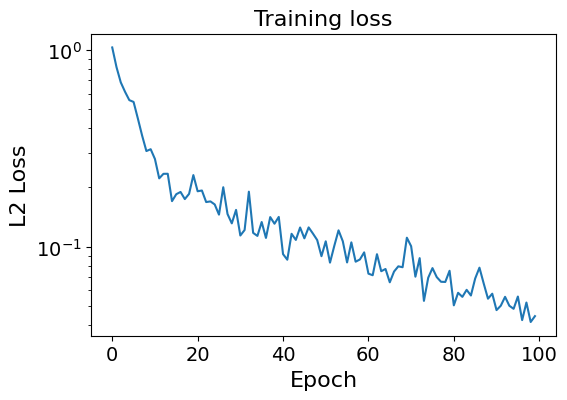

In [19]:
plt.figure(dpi=100)
plt.plot(np.array((ttrain)))
plt.yscale('log')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('L2 Loss',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Training loss',fontsize=16)

Text(0.5, 1.0, 'Testing loss')

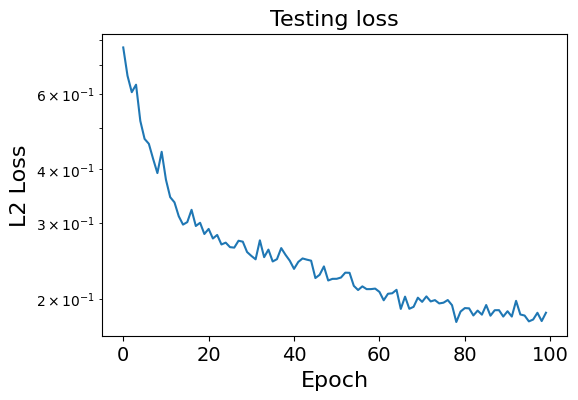

In [20]:
plt.figure(dpi=100)
plt.plot(np.array((ttest)))
plt.yscale('log')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('L2 Loss',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Testing loss',fontsize=16)

In [51]:
data_vali=[]
j = 360
grid = data[j][0]
input = data[j][1]
output = data[j][2]
meshgenerator = SCAMeshGenerator(grid, input, output)
grid = meshgenerator.get_grid()
input = meshgenerator.get_input()
output = meshgenerator.get_output()

edge_index = meshgenerator.ball_connectivity(radius_test)
print(grid.size())
print(edge_index.size())

edge_attr = meshgenerator.attributes(theta = input)
print(edge_attr.size())
# data_train.append(Data(x=init_point.clone().view(-1,1), y=train_y[j,:], edge_index=edge_index, edge_attr=edge_attr))
data_vali.append(Data(x=torch.cat([grid.reshape(-1, 2), input.reshape(-1, 3)], dim=1),X=grid, y=output, edge_index=edge_index, edge_attr=edge_attr))

train_vali = DataLoader(data_vali, batch_size=batch_size, shuffle=True)

torch.Size([128, 2])
torch.Size([2, 6152])
torch.Size([6152, 10])


<ipython-input-5-5755413e7f7e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.grid, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.input, dtype=torch.float)
<ipython-input-5-5755413e7f7e>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.output, dtype=torch.float)
/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' inst

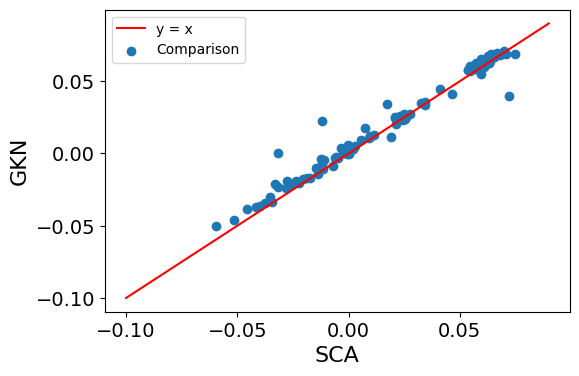

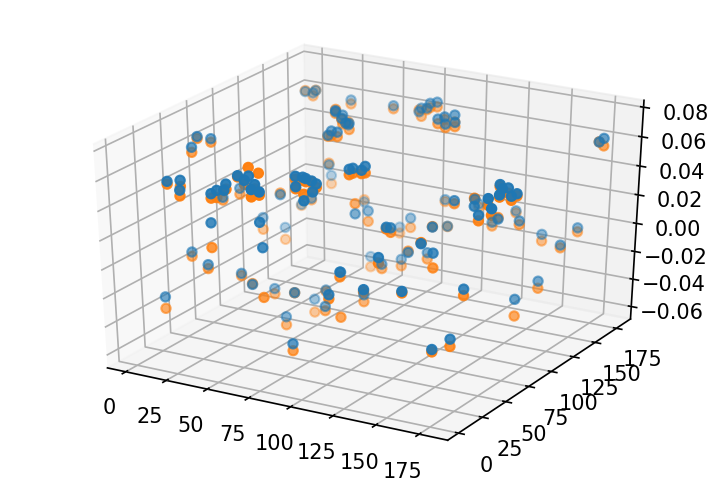

In [52]:
with torch.no_grad():
      for batch in train_vali:
          batch = batch.to(device)
          out = model(batch).detach().cpu()
          pred = batch.y.view(batch_size, -1).cpu()
out = out.numpy()
pred = pred.numpy()
pred = pred.flatten()
coor = batch.X.view(batch_size, -1).cpu().numpy().reshape(-1,1)

#coor, out, pred = denormalizer(coor, out, pred, mmax_strain, mmax_resp, mmax_coor)

out0 = out
pred0 = pred


plt.figure(dpi = 100)
plt.scatter(pred0, out0, label = 'Comparison') #assume amplitude 0.2


plt.xlabel('SCA',fontsize=16)
plt.ylabel('GKN',fontsize=16)
x=np.arange(-0.1, 0.1, 0.01)
y = x 

plt.plot(x,y, label = 'y = x', color = 'r')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
from sklearn.metrics import r2_score
r2_score(pred0, out0)

coor = batch.X.view(len(batch.X), 2).cpu().numpy()
coor = coor * 200
X = coor[:,0]
Y = coor[:,1]
Z = out
Z0 = pred
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
ax.scatter(X, Y, Z)
ax.scatter(X, Y, Z0)

In [ ]:
plt.figure(dpi = 100)
fac = 1
plt.step(coor, r[0, :]*fac, where = 'mid', label = 'r = 0.2') #assume amplitude 0.2
plt.step(coor, r[1, :]*fac, where = 'mid', label = 'r = 0.3') #assume amplitude 0.2
plt.step(coor, r[2, :]*fac, where = 'mid', label = 'r = 0.4') #assume amplitude 0.2
plt.step(coor, r[3, :]*fac, where = 'mid', label = 'r = 0.5') #assume amplitude 0.2
plt.step(coor, r[4, :]*fac, where = 'mid', label = 'r = 0.6') #assume amplitude 0.2
plt.step(coor, r[5, :]*fac, where = 'mid', label = 'r = 0.7') #assume amplitude 0.2
plt.step(coor, r[6, :]*fac, where = 'mid', label = 'r = 0.8')
plt.step(coor, pred*fac, where = 'mid', label = 'Reference SCA solution', linewidth = 2)
plt.xlabel('Coordinate',fontsize=16)
plt.ylabel('Strain',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Influence of r',fontsize=16)
plt.legend()

In [ ]:
domain_min = 0
domain_max = 10
length = domain_max-domain_min
far_strain = 0.2
 
ref_modulus = 3
num_clusters = 33

x = np.linspace(domain_min,domain_max,1000)
elastic_C =  1 / (1 + x**2)
from sklearn.cluster import KMeans
dataset=np.array(list(zip(x, elastic_C)))
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=0).fit(dataset)
point_cluster = np.array(list(zip(x,kmeans.labels_)))
Int_T = np.zeros((num_clusters, num_clusters), int)
np.fill_diagonal(Int_T, 1/ref_modulus)
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

sum = 0
for i in range(0,num_clusters):
    T_C = x[ClusterIndicesNumpy(i,kmeans.labels_)]
    C_ind = elastic_C[ClusterIndicesNumpy(i,kmeans.labels_)]
    int_Clus_C = np.trapz(C_ind,T_C)
    lim = len(T_C)
    length_C = T_C[lim-1]-T_C[0]
    ratio = length_C**2/int_Clus_C
    sum = sum + ratio
C_homo = 4/sum
sigma_overall = C_homo*far_strain
analytical_local_strain = sigma_overall/elastic_C

plt.plot(x, analytical_local_strain)

In [ ]:
l2=np.zeros((7))
l2[0] = np.linalg.norm(pred * fac - r[0, :]*fac)
l2[1] = np.linalg.norm(pred * fac - r[1, :]*fac)
l2[2] = np.linalg.norm(pred * fac - r[2, :]*fac)
l2[3] = np.linalg.norm(pred * fac - r[3, :]*fac)
l2[4] = np.linalg.norm(pred * fac - r[4, :]*fac)
l2[5] = np.linalg.norm(pred * fac - r[5, :]*fac)
l2[6] = np.linalg.norm(pred * fac - r[6, :]*fac)
l2

In [ ]:
GKN1 = out0
SCA1 = pred0

In [ ]:
plt.figure(dpi = 100)
plt.step(coor, GKN00, label = 'Kernel learning (far strain = 0.13)') #assume amplitude 0.2
plt.step(coor, SCA00, label = 'SCA (far strain = 0.13) ')

plt.step(coor, GKN0, label = 'Kernel learning (far strain = 0.26)') #assume amplitude 0.2
plt.step(coor, SCA0, label = 'SCA (far strain = 0.26)')


plt.step(coor, GKN1, label = 'Kernel learning (far strain = 0.39)') #assume amplitude 0.2
plt.step(coor, SCA1, label = 'SCA (far strain = 0.39)')

plt.xlabel('$\it{X}$',fontsize=16)
plt.ylabel('Strain',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Domain size = 10, cluster number = 43',fontsize=14)
plt.legend()